<a href="https://colab.research.google.com/github/Gaushoki/Adversarial-Patch-Attack/blob/main/Adversarial_patch_attack_22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Project: Adversarial Patch Attack

## Machine Learning & Deep Neural Network
Fall 2022

### Install libaries, dependencies and pre-trained models.

Optionally, you could train a model on preferred dataset for this experiment.

* The code for this project is adapted from the Deep Learning course at University of Amsterdam, by Phillip Lippe: https://uvadlc-notebooks.readthedocs.io/en/latest/ (The link includes other useful learning resources)

* Pretrained models sourced from https://github.com/huyvnphan/PyTorch_CIFAR10.git

* CIFAR10 Dataset downloaded from https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

In [ ]:
#Standard Libraries
import os
import json
import math
import time
import numpy as np 
import scipy.linalg

import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

#Pytorch and Torchvision Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
from tqdm.notebook import tqdm

#To generate plots
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')

from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.set()


# Make set GPU option for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cuda:0


In [ ]:
# Set the path for dataset and models
DATASET_PATH = "../data"
CHECKPOINT_PATH = "../saved_models/"
#If folder not set, create it
if not os.path.exists(CHECKPOINT_PATH):
  os.makedirs(CHECKPOINT_PATH)

In [ ]:
# Set the seed
pl.seed_everything(42)

In [ ]:
# Import and load pretrained model.
from cifar10_models.resnet import resnet34

my_model = resnet34(pretrained=True)
my_model.to(device)

#Set the evaluation mode with no gradient
my_model.eval()
for p in my_model.parameters():
    p.requires_grad = False

Prepare the CIFAR10 Dataset 

In [ ]:
# Set the Mean and Std
NORM_MEAN = np.array([0.49139968, 0.48215827, 0.44653124])
NORM_STD = np.array([0.24703233, 0.24348505, 0.26158768])

# The images are already preprocessed.
plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN,
                         std=NORM_STD)
    ])

#Set batch sizee
batch_size = 32

#Load the training dataset
trainset = torchvision.datasets.CIFAR10(root=DATASET_PATH, train=True,
                                        download=True, transform=plain_transforms)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=8)
#Load the testing dataset
testset = torchvision.datasets.CIFAR10(root=DATASET_PATH, train=False,
                                       download=True, transform=plain_transforms)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=8)

# Get the label names and index
label_names = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def get_label_index(lab_str):
    assert lab_str in label_names, f"Label \"{lab_str}\" not found. Check the spelling of the class."
    return label_names.index(lab_str)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../data/cifar-10-python.tar.gz to ../data


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  #


Files already downloaded and verified


In [ ]:
# Evaluate the baseline model
def eval_model(my_model, dataset_loader, img_func=None):
    tp, tp_5, counter = 0., 0., 0.
    for imgs, labels in tqdm(dataset_loader, desc="Validating..."):
        imgs = imgs.to(device)
        labels = labels.to(device)
        if img_func is not None:
            imgs = img_func(imgs, labels) 
        with torch.no_grad():
            preds = my_model(imgs)
        tp += (preds.argmax(dim=-1) == labels).sum()
        tp_5 += (preds.topk(5, dim=-1)[1] == labels[...,None]).any(dim=-1).sum()
        counter += preds.shape[0]
    acc = tp.float().item()/counter
    top5 = tp_5.float().item()/counter
    print(f"Top-1 error: {(100.0 * (1 - acc)):4.2f}%")
    print(f"Top-5 error: {(100.0 * (1 - top5)):4.2f}%")
    return acc, top5


In [ ]:
#Display the model predictions

def show_prediction(img, label, pred, K=5, adv_img=None, noise=None):

    if isinstance(img, torch.Tensor):
        img = img.cpu().permute(1, 2, 0).numpy()
        img = (img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        img = np.clip(img, a_min=0.0, a_max=1.0)
        label = label.item()
    
# Generate plot
    if noise is None or adv_img is None:
        fig, ax = plt.subplots(1, 2, figsize=(10,2), gridspec_kw={'width_ratios': [1, 1]})
    else:
        fig, ax = plt.subplots(1, 5, figsize=(12,2), gridspec_kw={'width_ratios': [1, 1, 1, 1, 2]})
    
    ax[0].imshow(img)
    ax[0].set_title(label_names[label])
    ax[0].axis('off')
    
    if adv_img is not None and noise is not None:
      
#Display some images and visualize noise
        adv_img = adv_img.cpu().permute(1, 2, 0).numpy()
        adv_img = (adv_img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        adv_img = np.clip(adv_img, a_min=0.0, a_max=1.0)
        ax[1].imshow(adv_img)
        ax[1].set_title('Adversarial')
        ax[1].axis('off')

        noise = noise.cpu().permute(1, 2, 0).numpy()
        noise = noise * 0.5 + 0.
        ax[2].imshow(noise)
        ax[2].set_title('Noise')
        ax[2].axis('off')

        ax[3].axis('off')
    
    if abs(pred.sum().item() - 1.0) > 1e-4:
        pred = torch.softmax(pred, dim=-1)
    topk_vals, topk_idx = pred.topk(K, dim=-1)
    topk_vals, topk_idx = topk_vals.cpu().numpy(), topk_idx.cpu().numpy()
    ax[-1].barh(np.arange(K), topk_vals*100.0, align='center', color=["C0" if topk_idx[i]!=label else "C2" for i in range(K)])
    ax[-1].set_yticks(np.arange(K))
    ax[-1].set_yticklabels([label_names[c] for c in topk_idx])
    ax[-1].invert_yaxis()
    ax[-1].set_xlabel('Confidence')
    ax[-1].set_title('Predictions')
    
    plt.show()
    plt.close()

##Baseline model evaluation(ResNET34)

In [ ]:
# Evaluate the baseline model
_ = eval_model(my_model, trainloader)

Validating...:   0%|          | 0/1563 [00:00<?, ?it/s]

Top-1 error: 0.10%
Top-5 error: 0.01%


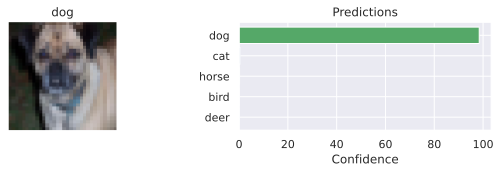

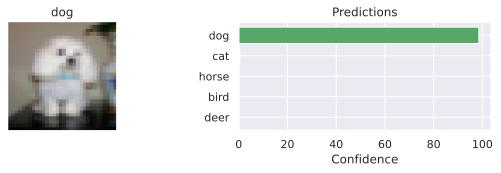

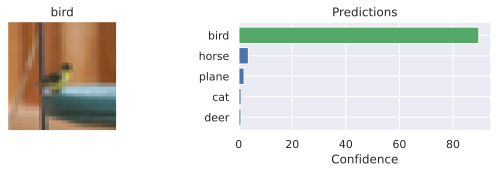

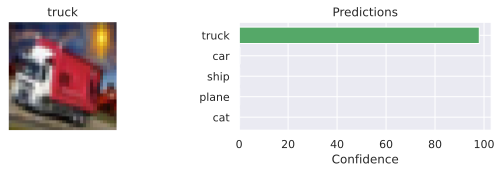

In [ ]:
# Show some model predictions
exmp_batch, label_batch = next(iter(trainloader))

with torch.no_grad():
    preds = my_model(exmp_batch.to(device))
for i in range(1,17,5):
    show_prediction(exmp_batch[i], label_batch[i], preds[i])

## Setup for patch training/attack

In [ ]:
# Setup the patch in random locations
def place_patch(img, patch):
  for i in range(img.shape[0]):
      h_offset = np.random.randint(0,img.shape[2]-patch.shape[1]-1)
      w_offset = np.random.randint(0,img.shape[3]-patch.shape[2]-1)
      img[i,:,
          h_offset:h_offset+patch.shape[1],
          w_offset:w_offset+patch.shape[2]] = patch_forward(patch)
  return img


TENSOR_MEANS, TENSOR_STD = (
torch.FloatTensor(NORM_MEAN)[:,None,None],
 torch.FloatTensor(NORM_STD)[:,None,None],)


def patch_forward(patch):
# Normalized patch values and mapped from [-infty,infty] to CIFAR10 min and max
  patch = (torch.tanh(patch) + 1 - 2 * TENSOR_MEANS) / (2 * TENSOR_STD)
  return patch

In [ ]:
#Create evaluation patch to test the validation set
def eval_patch(model, patch, val_loader, target_class):
  model.eval()
  tp, tp_5, counter = 0., 0., 0.
  with torch.no_grad():
        for img, img_labels in tqdm(val_loader, desc="Validating...", leave=False):
            
            for _ in range(4): # We choose 4 random patch placement locations
                patch_img = place_patch(img, patch)
                patch_img = patch_img.to(device)
                img_labels = img_labels.to(device)
                pred = model(patch_img)
                
            # Ignore the images that are of our target class
                tp += torch.logical_and(pred.argmax(dim=-1) == target_class, img_labels != target_class).sum()
                tp_5 += torch.logical_and((pred.topk(5, dim=-1)[1] == target_class).any(dim=-1), img_labels != target_class).sum()
                counter += (img_labels != target_class).sum()
                
     #Time the patch class is the top or top 5 prediction 
      acc = tp/counter
      top5 = tp_5/counter
  return acc, top5


In [ ]:
#Conduct patch attack on targeted class

def patch_attack(model, target_class, patch_size=4, num_epochs=5):

    train_set, val_set =
    torch.utils.data.random_split(trainset, [45000, 5000])
    train_loader = 
    data.DataLoader(train_set, batch_size=32, shuffle=True, drop_last=True, num_workers=8)
    val_loader = 
    data.DataLoader(val_set, batch_size=32, shuffle=False, drop_last=False, num_workers=4)
    
#Set the optimizer
    if not isinstance(patch_size, tuple):
        patch_size = (patch_size, patch_size)
    patch = nn.Parameter(torch.zeros(3, patch_size[0], patch_size[1]), requires_grad=True)

    optimizer = torch.optim.SGD([patch],
    lr=1e-1, momentum=0.8)
    loss_module = nn.CrossEntropyLoss()
    
#The training patch loop
    for epoch in range(num_epochs):
        t = tqdm(train_loader, leave=False)
        for img, _ in t:
            img = place_patch(img, patch)
            img = img.to(device)
            pred = model(img)
            labels = torch.zeros(img.shape[0], device=pred.device, dtype=torch.long).fill_(target_class)
            loss = loss_module(pred, labels)
            optimizer.zero_grad()
            loss.mean().backward()
            optimizer.step()
            t.set_description(f"Epoch {epoch}, Loss: {loss.item():4.2f}")
    
#Validation
    acc, top5 = eval_patch(model, patch, val_loader, target_class)
    
    return patch.data, {"acc": acc.item(), "top5": top5.item()}


In [ ]:
# Function to conduct patch attack on different classes and patch sizes

def get_patches(my_model, class_names, patch_sizes, evaluate=False):
    result_dict = dict()

    #We loop over all 10 classes and 4 patch sizes
    for name in class_names:
        result_dict[name] = dict()
        for patch_size in patch_sizes:
            c = label_names.index(name)
            file_name = os.path.join(CHECKPOINT_PATH, f"{name}_{patch_size}_patch.pt")

        #Load trained patch if availalble or start training
            if not os.path.isfile(file_name):
                print('Training patch')

                patch, val_results = patch_attack(my_model, target_class=c, patch_size=patch_size, num_epochs=5)
                print(f"Validation results for {name} and {patch_size}:", val_results)
                if not os.path.exists(os.path.dirname(file_name)):
                    os.makedirs(os.path.dirname(file_name))
                torch.save(patch, file_name)
            else:
                print("Patch found")

                patch = torch.load(file_name)
            if evaluate:
                results = eval_patch(my_model, patch, trainloader, target_class=c)
            else:
              results = ['Patch not evaluated']
            
        #Save training patch results in a dict
            result_dict[name][patch_size] = {
                "results": results,
                "patch": patch
            }
        
    return result_dict

In [ ]:
#Function to write patches and results in json file 
def save_results(patch_dict):
    result_dict = {cname: {psize: [t.item() if isinstance(t, torch.Tensor) else t 
                                   for t in patch_dict[cname][psize]["results"]] 
                           for psize in patch_dict[cname]} 
                   for cname in patch_dict}
    with open(os.path.join(CHECKPOINT_PATH, "patch_results.json"), "w") as f:
        json.dump(result_dict, f, indent=4)

#Display the patches after training
def show_patches(patch_dict):
    fig, ax = plt.subplots(len(patch_sizes), len(class_names), figsize=(len(class_names)*2.2, len(patch_sizes)*2.2))
    for c_idx, cname in enumerate(class_names):
        for p_idx, psize in enumerate(patch_sizes):
            patch = patch_dict[cname][psize]['patch']
            patch = (torch.tanh(patch) + 1) / 2 
            patch = patch.cpu().permute(1, 2, 0).numpy()
            patch = np.clip(patch, a_min=0.0, a_max=1.0)
            ax[p_idx][c_idx].imshow(patch)
            ax[p_idx][c_idx].set_title(f"{cname}, size {psize}")
            ax[p_idx][c_idx].axis('off')
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.show()

In [ ]:
# Conduct attack on model
def perform_patch_attack(my_model, patch):

  patch_batch = exmp_batch.clone()
  patchy_batch = place_patch(patch_batch, patch)
  with torch.no_grad():
      patch_preds = my_model(patch_batch.to(device))
  for i in range(0,len(patch_batch),5):
      show_prediction(patchy_batch[i], label_batch[i], patch_preds[i])


def eval_patch_model(my_model, dataset_loader, patch, img_func=None):
    tp, tp_5, counter = 0., 0., 0.
    for imgs, labels in tqdm(dataset_loader, desc="Validating..."):
        imgs = place_patch(imgs, patch)
        imgs = imgs.to(device)
        labels = labels.to(device)
        if img_func is not None:
            imgs = img_func(imgs, labels) 
        with torch.no_grad():
            preds = my_model(imgs)
        tp += (preds.argmax(dim=-1) == labels).sum()
        tp_5 += (preds.topk(5, dim=-1)[1] == labels[...,None]).any(dim=-1).sum()
        counter += preds.shape[0]
        
    acc = tp.float().item()/counter
    top5 = tp_5.float().item()/counter

    print(f"Top-1 error: {(100.0 * (1-acc)):4.2f}%")
    print(f"Top-5 error: {(100.0 * (1-top5)):4.2f}%")
    return acc, top5

Patch Training

In [ ]:
#Train patches on all 10 classes
class_names = ['plane','bird', 'truck', 'deer', 'car', 'dog', 'bird','ship', 'cat', 'frog']

#Patch sizes to be trained
patch_sizes = [3, 5, 7, 16]

# Get pre-trained patches and save new trained patches
patch_dict = get_patches(my_model, class_names, patch_sizes, evaluate=False)
save_results(patch_dict) 

## Patch Attack!
- Visualize patches and patch results on training data
- Perform patch attack on the baseline (ResNet34) model
- Perform patch transfer attack on ResNet18
- Perform patch transfer attack on Vgg16 

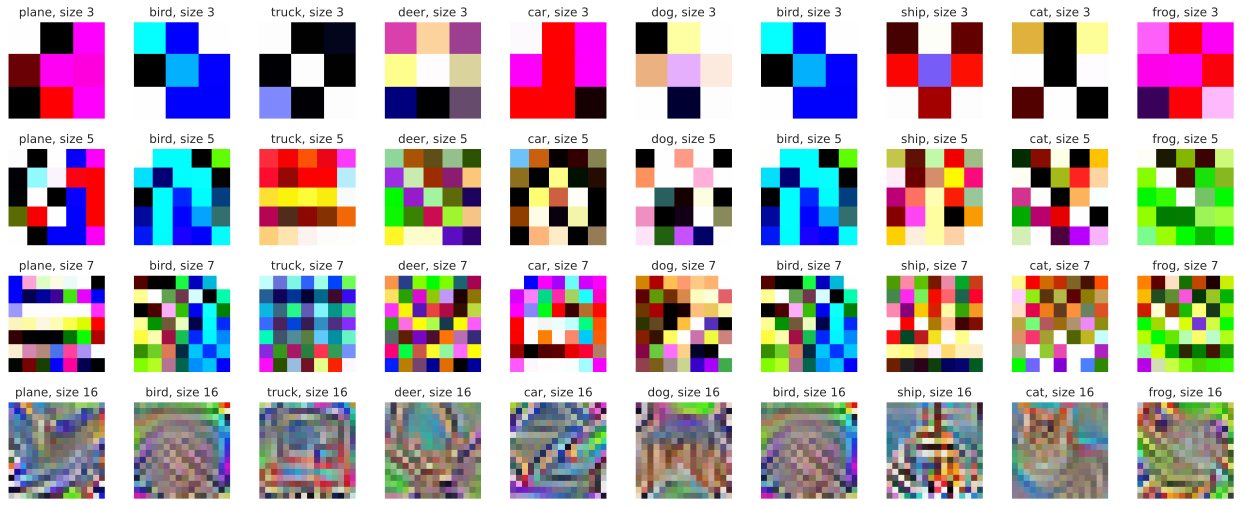

In [ ]:
#Show the trained patches
show_patches(patch_dict)

## Select class and patch size for performing attack

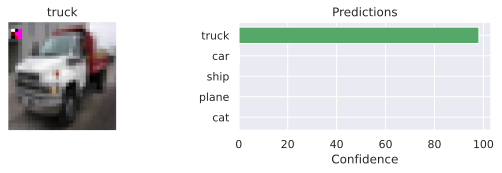

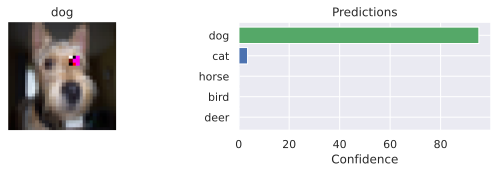

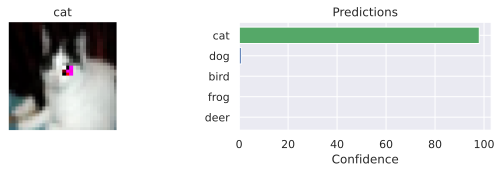

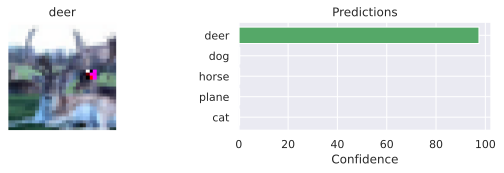

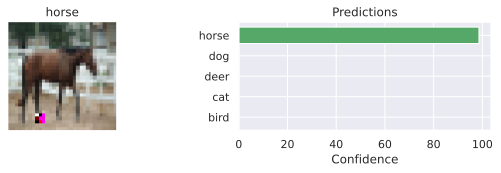

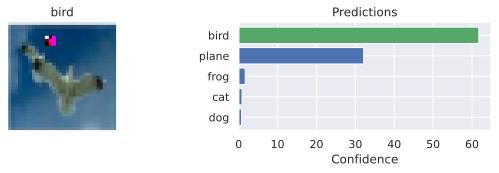

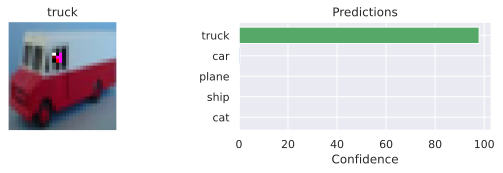

In [ ]:
cl = 'plane' #Set patch class
s = 3        #Set the patch size

#Perform patch attack
perform_patch_attack(my_model, patch_dict[cl][s]['patch'])

In [ ]:
# Change the class to another trained patch
cl = 'deer'
print("Evaluate ResNet34 error\n")
print(f'Patch class: {cl}\n')

print('No patch')
_ = eval_model(my_model,testloader)

for psize in patch_sizes:
  print(f"\nPatch size {psize}")
  _ = eval_patch_model(my_model, testloader, patch_dict[cl][psize]['patch'])

Evaluate ResNet34 error

Patch class: deer

No patch


Validating...:   0%|          | 0/313 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  #


Top-1 error: 6.67%
Top-5 error: 0.25%

Patch size 3


Validating...:   0%|          | 0/313 [00:00<?, ?it/s]

Top-1 error: 11.41%
Top-5 error: 0.67%

Patch size 5


Validating...:   0%|          | 0/313 [00:00<?, ?it/s]

Top-1 error: 15.52%
Top-5 error: 1.00%

Patch size 7


Validating...:   0%|          | 0/313 [00:00<?, ?it/s]

Top-1 error: 31.00%
Top-5 error: 3.38%

Patch size 16


Validating...:   0%|          | 0/313 [00:00<?, ?it/s]

Top-1 error: 90.00%
Top-5 error: 43.76%


In [ ]:

cl = 'frog' #Set the patch class

print('Evaluate accuracy on ResNet34\n')
print(f'Patch class: {cl}')

for psize in patch_sizes:
  print(f"\nPatch size {psize}")
  top1, top5 = eval_patch(my_model, patch_dict[cl][psize]['patch'], testloader, get_label_index(cl))
  print(f"Top1 accuracy: {100*top1.item():.2f}%, Top5 accuracy: {100*top5.item():.2f}%")

Evaluate accuracy on ResNet34

Patch class: frog

Patch size 3


Validating...:   0%|          | 0/313 [00:00<?, ?it/s]

Top1 accuracy: 0.20%, Top5 accuracy: 9.08%

Patch size 5


Validating...:   0%|          | 0/313 [00:00<?, ?it/s]

Top1 accuracy: 24.43%, Top5 accuracy: 68.08%

Patch size 7


Validating...:   0%|          | 0/313 [00:00<?, ?it/s]

Top1 accuracy: 62.29%, Top5 accuracy: 92.39%

Patch size 16


Validating...:   0%|          | 0/313 [00:00<?, ?it/s]

Top1 accuracy: 99.99%, Top5 accuracy: 100.00%


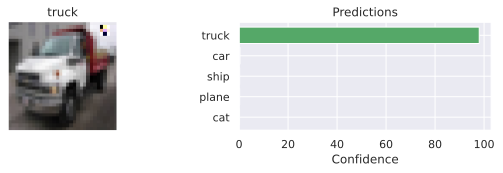

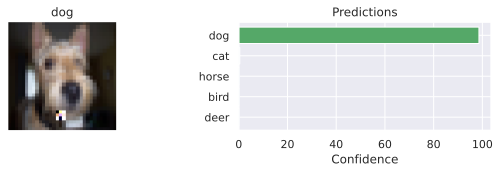

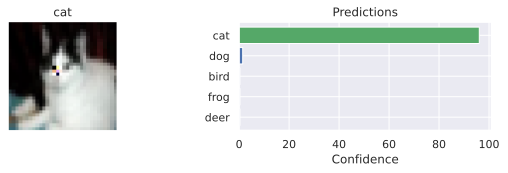

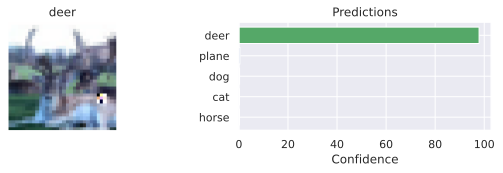

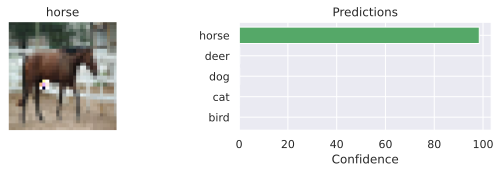

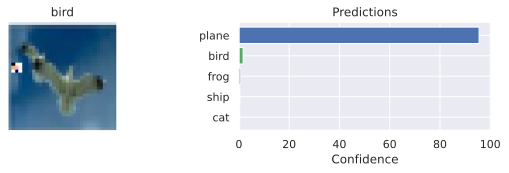

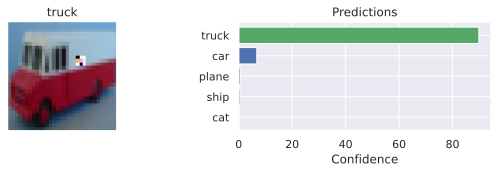

In [ ]:
cl = 'dog' # Set the class for display
s = 3      # Set the patch size

#Perform attack
perform_patch_attack(my_model, patch_dict[cl][s]['patch'])

### Transfer and test attack on a different Model = Resnet18

In [ ]:
#Import and load pretrained models
from cifar10_models.resnet import resnet18
res18_model = resnet18(pretrained=True)

from cifar10_models.vgg import vgg16_bn
vgg16_model = vgg16_bn(pretrained=True)

In [ ]:
# Set the patch class and evaluate on new model with all 4 patch sizes
cl = 'deer' 

res18_model.to(device)
print("Evaluate ResNet18 error\n")
print(f'Patch class: {cl}')

res18_model.eval()
for p in res18_model.parameters():
    p.requires_grad = False
print("No patch")

_ = eval_model(res18_model,testloader)
print('\n')

for psize in patch_sizes:
  print(f"\nPatch size {psize}")
  _ = eval_patch_model(res18_model, testloader, patch_dict[cl][psize]['patch'])
  print('\n')

Evaluate ResNet18 error

Patch class: deer
No patch


Validating...:   0%|          | 0/313 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  #


Top-1 error: 6.93%
Top-5 error: 0.26%



Patch size 3


Validating...:   0%|          | 0/313 [00:00<?, ?it/s]

Top-1 error: 12.77%
Top-5 error: 0.64%



Patch size 5


Validating...:   0%|          | 0/313 [00:00<?, ?it/s]

Top-1 error: 17.12%
Top-5 error: 0.82%



Patch size 7


Validating...:   0%|          | 0/313 [00:00<?, ?it/s]

Top-1 error: 24.42%
Top-5 error: 1.72%



Patch size 16


Validating...:   0%|          | 0/313 [00:00<?, ?it/s]

Top-1 error: 89.74%
Top-5 error: 32.33%




In [ ]:
# Switch the patch class and evaluate on new model
cl = 'car'

print('Evaluate patch accuracy on ResNet18\n')
print(f'Patch class: {cl}')

for psize in patch_sizes:
  print(f"\nPatch size {psize}")
  top1, top5 = eval_patch(res18_model, patch_dict[cl][psize]['patch'], testloader, get_label_index(cl))
  print(f"Top1 accuracy: {100*top1.item():.2f}%, Top5 accuracy: {100*top5.item():.2f}%")

Evaluate patch accuracy on ResNet18

Patch class: car

Patch size 3


Validating...:   0%|          | 0/313 [00:00<?, ?it/s]

Top1 accuracy: 6.82%, Top5 accuracy: 56.14%

Patch size 5


Validating...:   0%|          | 0/313 [00:00<?, ?it/s]

Top1 accuracy: 7.75%, Top5 accuracy: 56.18%

Patch size 7


Validating...:   0%|          | 0/313 [00:00<?, ?it/s]

Top1 accuracy: 34.33%, Top5 accuracy: 86.60%

Patch size 16


Validating...:   0%|          | 0/313 [00:00<?, ?it/s]

Top1 accuracy: 99.09%, Top5 accuracy: 100.00%


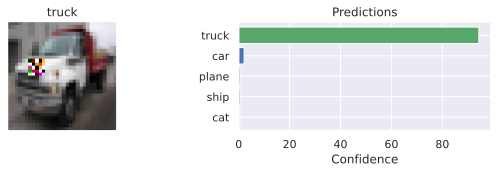

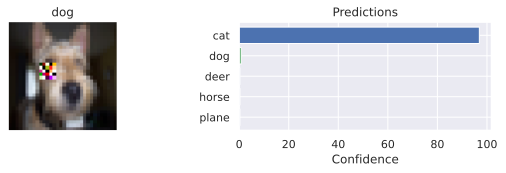

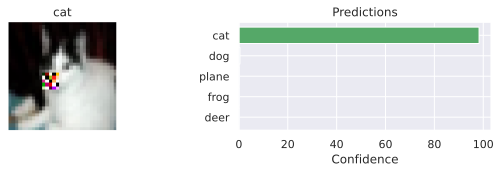

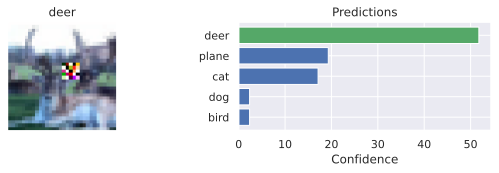

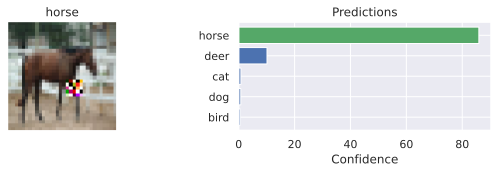

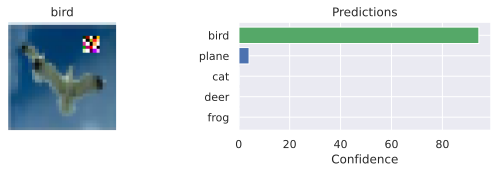

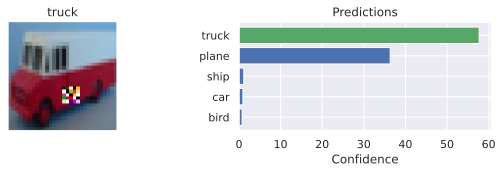

In [ ]:

cl = 'cat'  #Set class to display the attack
s = 5       #Set the patch size

#Perform the attack
perform_patch_attack(res18_model, patch_dict[cl][s]['patch'])

### Transfer and test attack on a different Model = Vgg16

In [ ]:
# Set patch class
cl = 'truck'

vgg16_model.to(device)
print('Evaluating Vgg16 error \n')
print(f"Patch class: {cl}\n")

vgg16_model.eval()
for p in vgg16_model.parameters():
    p.requires_grad = False
print("No patch")
_ = eval_model(vgg16_model,testloader)
print('\n')

for psize in patch_sizes:
  print(f"\nPatch size {psize}")
  _ = eval_patch_model(vgg16_model, testloader, patch_dict[cl][psize]['patch'])
  print('\n')

Evaluating Vgg16 error 

Patch class: truck

No patch


Validating...:   0%|          | 0/313 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  #


Top-1 error: 6.00%
Top-5 error: 0.36%



Patch size 3


Validating...:   0%|          | 0/313 [00:00<?, ?it/s]

Top-1 error: 21.95%
Top-5 error: 3.22%



Patch size 5


Validating...:   0%|          | 0/313 [00:00<?, ?it/s]

Top-1 error: 15.46%
Top-5 error: 2.62%



Patch size 7


Validating...:   0%|          | 0/313 [00:00<?, ?it/s]

Top-1 error: 19.36%
Top-5 error: 3.90%



Patch size 16


Validating...:   0%|          | 0/313 [00:00<?, ?it/s]

Top-1 error: 88.00%
Top-5 error: 46.46%




In [ ]:
#Set patch class to evaluate
cl = 'frog'

print('Evaluating patch accuracy on Vgg16\n')
print(f"Patch class: {cl}")

for psize in patch_sizes:
  print(f"\nPatch size {psize}")
  top1, top5 = eval_patch(vgg16_model, patch_dict[cl][psize]['patch'], testloader, get_label_index(cl))
  print(f"Top1 acc: {100*top1.item():.2f}%, Top5 acc: {100*top5.item():.2f}%")

Evaluating patch accuracy on Vgg16

Patch class: frog

Patch size 3


Validating...:   0%|          | 0/313 [00:00<?, ?it/s]

Top1 acc: 0.25%, Top5 acc: 32.23%

Patch size 5


Validating...:   0%|          | 0/313 [00:00<?, ?it/s]

Top1 acc: 5.88%, Top5 acc: 57.53%

Patch size 7


Validating...:   0%|          | 0/313 [00:00<?, ?it/s]

Top1 acc: 10.72%, Top5 acc: 66.36%

Patch size 16


Validating...:   0%|          | 0/313 [00:00<?, ?it/s]

Top1 acc: 97.69%, Top5 acc: 99.92%


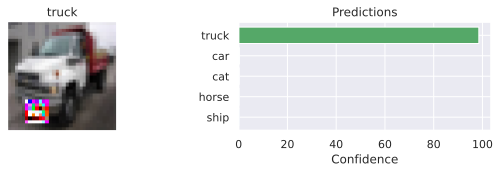

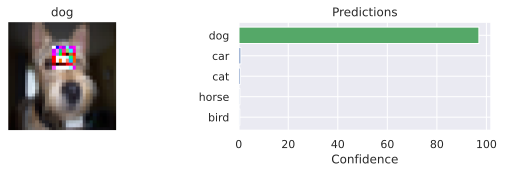

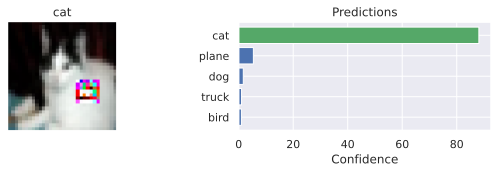

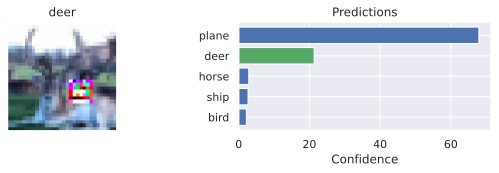

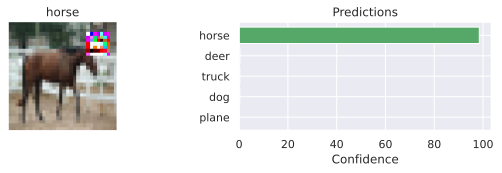

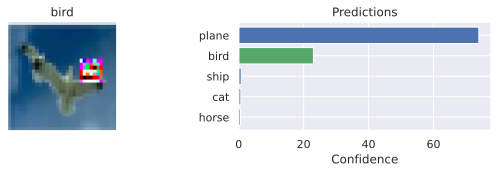

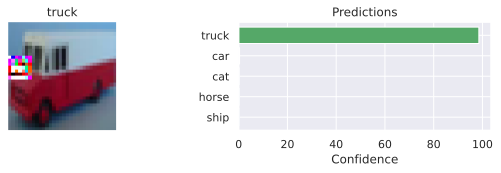

In [ ]:
cl = 'car'  #Select patch class to display
s = 7       #Set the patch size

perform_patch_attack(vgg16_model, patch_dict[cl][s]['patch'])

#     **Sources**




[1] Brown, B., T. et. al. Adversarial Patch https://arxiv.org/pdf/1712.09665.pdf

[2] Lippe, P. UvA Deep Learning Tutorials. https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial10/Adversarial_Attacks.html.  2022.

[3] Balis, J. A Minimalist PyTorch Physical Adversarial Patch Attack.  https://balisujohn.github.io/pytorch-adversarial-patch/ 2021

[4] Simonyan et. al 2014. https://arxiv.org/abs/1409.1556.

[5] Hayes, J. Adversarial Patch. https://github.com/jhayes14/adversarial-patch 2018

[6] Xiang, L. & Shihao, J. Generative Dynamic Patch Attack. https://arxiv.org/pdf/2111.04266.pdf

[7] Xin, L., DPATCH: An Adversarial Patch Attack on Object Detectors. https://arxiv.org/pdf/1806.02299.pdf 